## Importing librairies

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from loading_data import *
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import sqrt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from scipy import stats

In [228]:
!pip install pwlf

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18196 sha256=c3dcc73761aeb33af1e68a86a997dd547a10ea740d340e21b521edebe0dfabe0
  Stored in directory: c:\users\ali\appdata\local\pip\cache\wheels\84\20\8c\8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


In [229]:
import pwlf

In [200]:
ncg_consumption, gaspool_consumption, the_consumption = read_consumption()
consumption_data = pd.concat([ncg_consumption.add(gaspool_consumption, fill_value=0), the_consumption])
df_consumption = consumption_data.to_frame(name='consumption')

# avoir le premier et le dernier index de la série
start_date = consumption_data.index[0].strftime("%Y-%m-%d")
end_date = consumption_data.index[-1].strftime("%Y-%m-%d")

weather = read_weather()
# afficher les colonnes du dataframe
print(weather.columns)
temp_2m_mean = weather["temperature_2m_mean (°C)"]
temp_2m_mean = temp_2m_mean[start_date:end_date] # avoir les dates des températures maximales à partir de start_date jusqu'à end_date


Index(['temperature_2m_max (°C)', 'temperature_2m_min (°C)',
       'temperature_2m_mean (°C)', 'sunshine_duration (h)',
       'wind_speed_10m_max (km/h)'],
      dtype='object')


In [201]:
temp_2m_mean

Date
2011-04-01    12.7
2011-04-02    14.3
2011-04-03    15.3
2011-04-04    10.6
2011-04-05    10.0
              ... 
2024-10-27    11.6
2024-10-28    11.8
2024-10-29    13.1
2024-10-30    12.9
2024-10-31    11.7
Name: temperature_2m_mean (°C), Length: 4963, dtype: float64

In [202]:
#Conso mensuelle
gas_consumption_monthly = df_consumption.resample('M').sum()
temp_2m_mean_monthly = temp_2m_mean.loc[start_date:end_date].resample('M').mean()


In [233]:
#Filtrage sur l'hiver

cold_months = [1, 2, 3, 10, 11, 12]

# Filtrer sur les mois froids pour les deux séries
gas_consumption_cold_months = gas_consumption_monthly[gas_consumption_monthly.index.month.isin(cold_months)]
temp_2m_mean_cold_months = temp_2m_mean_monthly[temp_2m_mean_monthly.index.month.isin(cold_months)]

             consumption
2011-10-31  4.260749e+07
2011-11-30  5.523092e+07
2011-12-31  6.002006e+07
2012-01-31  6.648466e+07
2012-02-29  7.624201e+07
...                  ...
2023-12-31  1.025127e+08
2024-01-31  1.205233e+08
2024-02-29  8.635184e+07
2024-03-31  8.257559e+07
2024-10-31  6.365285e+07

[79 rows x 1 columns]
Date
2011-10-31    10.387097
2011-11-30     4.610000
2011-12-31     4.219355
2012-01-31     1.864516
2012-02-29    -1.893103
                ...    
2023-12-31     3.709677
2024-01-31     1.261290
2024-02-29     6.627586
2024-03-31     7.603226
2024-10-31    11.512903
Name: temperature_2m_mean (°C), Length: 79, dtype: float64


In [203]:
gas_consumption_monthly

,consumption
2011-04-30,3.461649e+07
2011-05-31,3.179633e+07
2011-06-30,2.605131e+07
2011-07-31,2.729786e+07
2011-08-31,2.573426e+07
...,...
2024-06-30,4.282684e+07
2024-07-31,3.910594e+07
2024-08-31,3.715510e+07
2024-09-30,4.464442e+07


In [162]:
consumption_data.corr(temp_2m_mean)

-0.7536698980266934

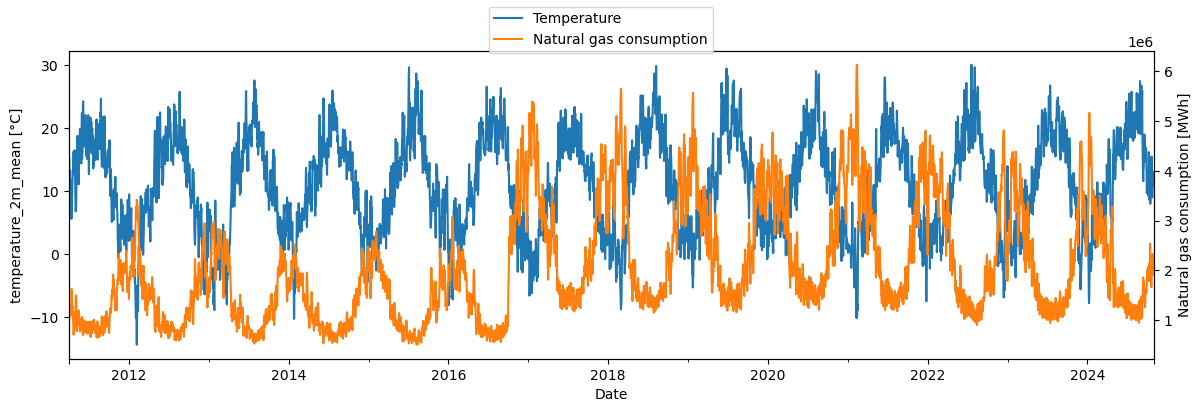

In [163]:
fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

# For both, only show data in 2021 and 2022
temp_2m_mean.loc[start_date:end_date].plot(ax=ax1, color="tab:blue")
consumption_data.plot(ax=ax2, color="tab:orange")

# Labels and legend
ax1.set_ylabel("temperature_2m_mean [°C]")
ax2.set_ylabel("Natural gas consumption [MWh]")

# Legend for both plots in one
fig.legend(
    labels=["Temperature", "Natural gas consumption"],

    loc="upper center",
)

# Create directory if it does not exist
os.makedirs("diagrams", exist_ok=True)

# Save plot
fig.savefig("diagrams/temp_conso_daily.svg", format="svg", bbox_inches="tight")

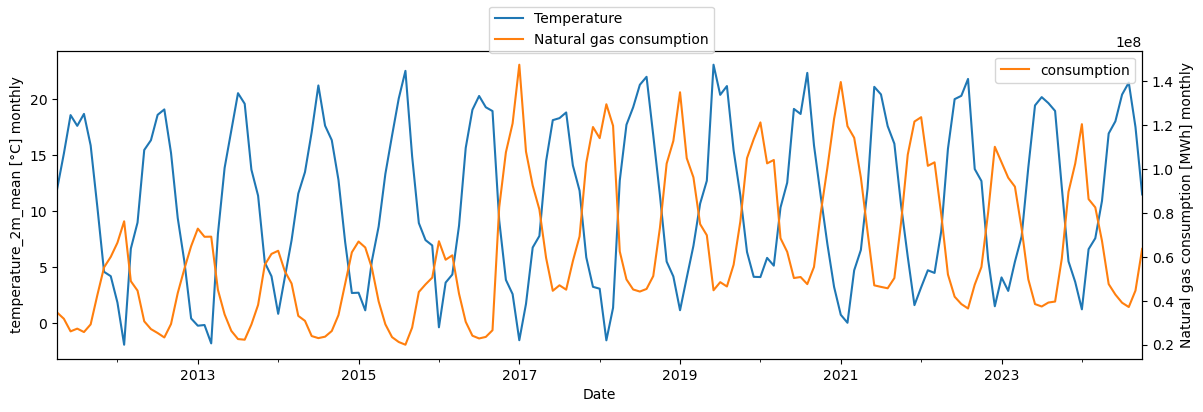

In [164]:
fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

# For both, only show data in 2021 and 2022
temp_2m_mean_monthly.plot(ax=ax1, color="tab:blue")
gas_consumption_monthly.plot(ax=ax2, color="tab:orange")

# Labels and legend
ax1.set_ylabel("temperature_2m_mean [°C] monthly")
ax2.set_ylabel("Natural gas consumption [MWh] monthly")

# Legend for both plots in one
fig.legend(
    labels=["Temperature", "Natural gas consumption"],

    loc="upper center",
)

# Create directory if it does not exist
os.makedirs("diagrams", exist_ok=True)

# Save plot
fig.savefig("diagrams/temp_conso_monthly.svg", format="svg", bbox_inches="tight")

In [165]:
gas_consumption_monthly['consumption'].corr(temp_2m_mean_monthly)

-0.7618906132358104

In [166]:
#Nb d'heures ou 1m2 recoit plus de 120 Watts 
sunshine_dur = weather["sunshine_duration (h)"]
sunshine_dur = sunshine_dur.loc[start_date:end_date]
sunshine_dur

Date
2011-04-01     6.630931
2011-04-02     7.479119
2011-04-03    11.736578
2011-04-04     6.082192
2011-04-05     9.298789
                ...    
2024-10-27     5.493553
2024-10-28     2.000000
2024-10-29     0.000000
2024-10-30     2.199706
2024-10-31     2.540353
Name: sunshine_duration (h), Length: 4963, dtype: float64

In [198]:
consumption_data.corr(sunshine_dur)

-0.49751422900229897

In [168]:
#Nb de secondes ou 1m2 recoit plus de 120 Watts 
wind_speed_10m_max = weather["wind_speed_10m_max (km/h)"]
wind_speed_10m_max = wind_speed_10m_max.loc[start_date:end_date]
wind_speed_10m_max

Date
2011-04-01    25.5
2011-04-02    16.3
2011-04-03    15.8
2011-04-04    16.3
2011-04-05    17.3
              ... 
2024-10-27    22.5
2024-10-28    17.4
2024-10-29    16.4
2024-10-30    18.5
2024-10-31    21.9
Name: wind_speed_10m_max (km/h), Length: 4963, dtype: float64

In [169]:
consumption_data.corr(wind_speed_10m_max)

0.1315934701040311

In [170]:
sunshine_dur_monthly = sunshine_dur.resample('M').mean()
wind_speed_10m_max_monthly = wind_speed_10m_max.resample('M').mean()


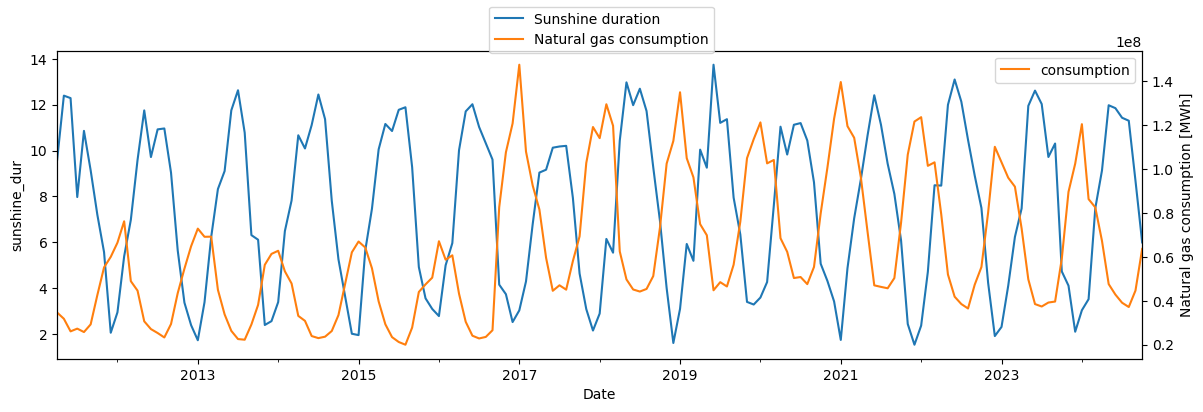

In [171]:
fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

sunshine_dur_monthly.plot(ax=ax1, color="tab:blue")
gas_consumption_monthly.plot(ax=ax2, color="tab:orange")

ax1.set_ylabel("sunshine_dur")
ax2.set_ylabel("Natural gas consumption [MWh]")

fig.legend(
    labels=["Sunshine duration", "Natural gas consumption"],

    loc="upper center",
)

os.makedirs("diagrams", exist_ok=True)

# Save plot
fig.savefig("diagrams/sunshine_duration_analysis.svg", format="svg", bbox_inches="tight")

In [172]:
gas_consumption_monthly['consumption'].corr(sunshine_dur_monthly)

-0.7062972340754698

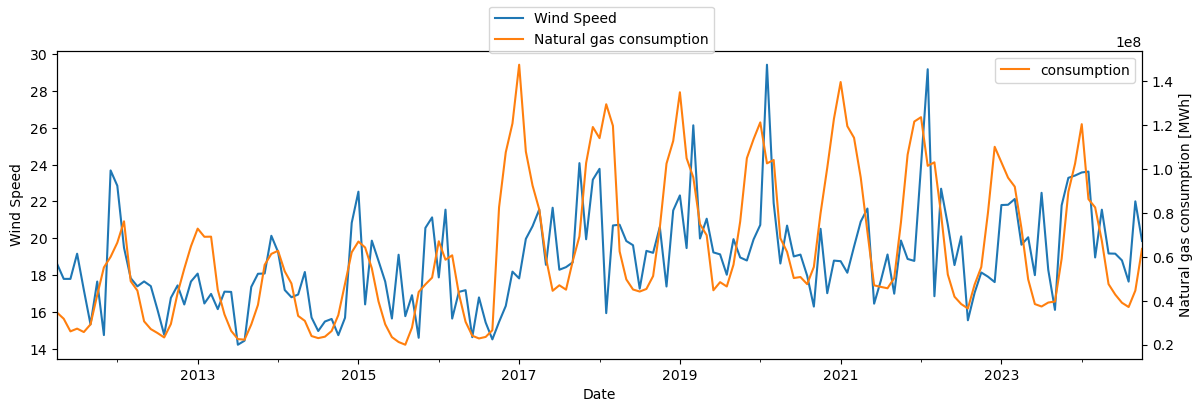

In [173]:
fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

wind_speed_10m_max_monthly.plot(ax=ax1, color="tab:blue")
gas_consumption_monthly.plot(ax=ax2, color="tab:orange")

ax1.set_ylabel("Wind Speed")
ax2.set_ylabel("Natural gas consumption [MWh]")

fig.legend(
    labels=["Wind Speed", "Natural gas consumption"],

    loc="upper center",
)

os.makedirs("diagrams", exist_ok=True)

# Save plot
fig.savefig("diagrams/wind_speed_analysis.svg", format="svg", bbox_inches="tight")

In [174]:
gas_consumption_monthly['consumption'].corr(wind_speed_10m_max_monthly)

0.4924773723802814

## Stationnarity analysis

In [175]:
from statsmodels.tsa.stattools import adfuller

# Fonction pour tester la stationnarité d'une série
def test_stationarity(series):
    result = adfuller(series.dropna())
    return result[1] < 0.05  # Retourne True si la série est stationnaire

# Fonction pour rendre une série stationnaire
def make_series_stationary(series, max_diff=5):
    diff_count = 0
    while not test_stationarity(series) and diff_count < max_diff:
        series = series.diff()
        diff_count += 1
    return series


In [176]:
#The goal is to see if we can improve the correlation by removing the trending/seasonality effect by making the time series stationnary

#gas_consumption_monthly = gas_consumption_monthly.fillna(method='ffill')
gas_consumption_monthly_st = make_series_stationary(gas_consumption_monthly['consumption'])

#wind_speed_10m_max_monthly = wind_speed_10m_max_monthly.fillna(method='ffill')
wind_speed_10m_max_monthly_st = make_series_stationary(wind_speed_10m_max_monthly)

#sunshine_dur_monthly = sunshine_dur_monthly.fillna(method='ffill')
sunshine_dur_monthly_st = make_series_stationary(sunshine_dur_monthly)


In [177]:
temp_2m_mean_monthly_st = make_series_stationary(temp_2m_mean_monthly)

In [178]:
temp_2m_mean_monthly_st

Date
2011-04-30         NaN
2011-05-31    3.128280
2011-06-30    3.435054
2011-07-31   -0.957634
2011-08-31    1.064516
                ...   
2024-06-30    1.088172
2024-07-31    2.386022
2024-08-31    1.067742
2024-09-30   -3.960430
2024-10-31   -6.013763
Freq: M, Name: temperature_2m_mean (°C), Length: 163, dtype: float64

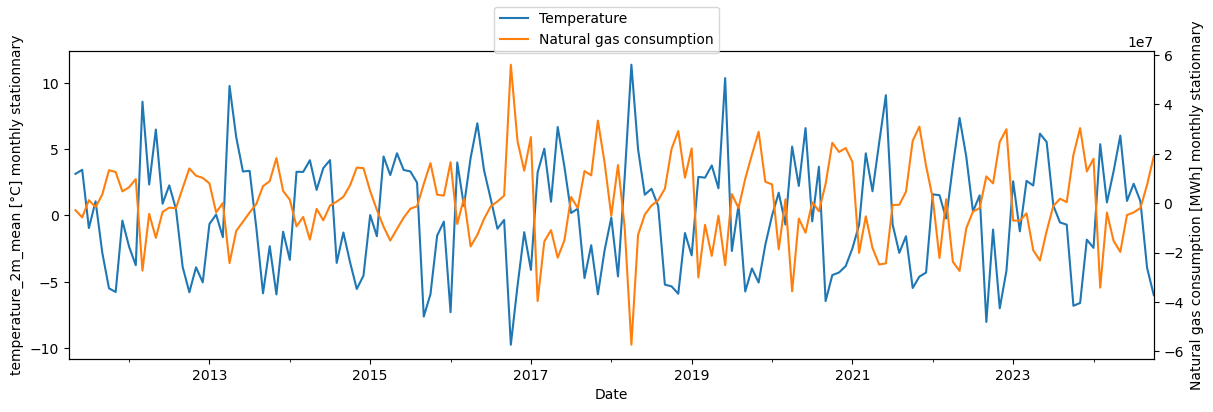

In [179]:
fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

# For both, only show data in 2021 and 2022
temp_2m_mean_monthly_st.plot(ax=ax1, color="tab:blue")
gas_consumption_monthly_st.plot(ax=ax2, color="tab:orange")

# Labels and legend
ax1.set_ylabel("temperature_2m_mean [°C] monthly stationnary")
ax2.set_ylabel("Natural gas consumption [MWh] monthly stationnary")

# Legend for both plots in one
fig.legend(
    labels=["Temperature", "Natural gas consumption"],

    loc="upper center",
)

# Create directory if it does not exist
os.makedirs("diagrams", exist_ok=True)

# Save plot
fig.savefig("diagrams/temp_conso_monthly_stationnary.svg", format="svg", bbox_inches="tight")

In [180]:
gas_consumption_monthly_st.corr(temp_2m_mean_monthly_st)

-0.8605553305766885

## Linear Regression

In [181]:
train_size = 0.8  # 80% pour l'entraînement, 20% pour le test
train, test = train_test_split(pd.concat([gas_consumption_monthly, temp_2m_mean_monthly,sunshine_dur_monthly,wind_speed_10m_max_monthly], axis=1), 
                               test_size=1-train_size, shuffle=False)

X_test = test['temperature_2m_mean (°C)'].values.reshape(-1, 1)
y_test = test['consumption'].values



X_train = train['temperature_2m_mean (°C)'].values.reshape(-1, 1)  # Température comme variable indépendante
y_train = train['consumption'].values  # Consommation de gaz comme cible

model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions sur le test set
y_pred = model.predict(X_test)

# Calcul de la MSE pour cette régression
mse = mean_squared_error(y_test, y_pred)
print(f'MSE (temp_2m_mean_monthly -> gas_consumption_monthly): {mse}')
r2 = model.score(X_test, y_test)
print(f'R^2 (temp_2m_mean_monthly -> gas_consumption_monthly): {r2}')


MSE (temp_2m_mean_monthly -> gas_consumption_monthly): 127378807983273.97
R^2 (temp_2m_mean_monthly -> gas_consumption_monthly): 0.8139464071365637


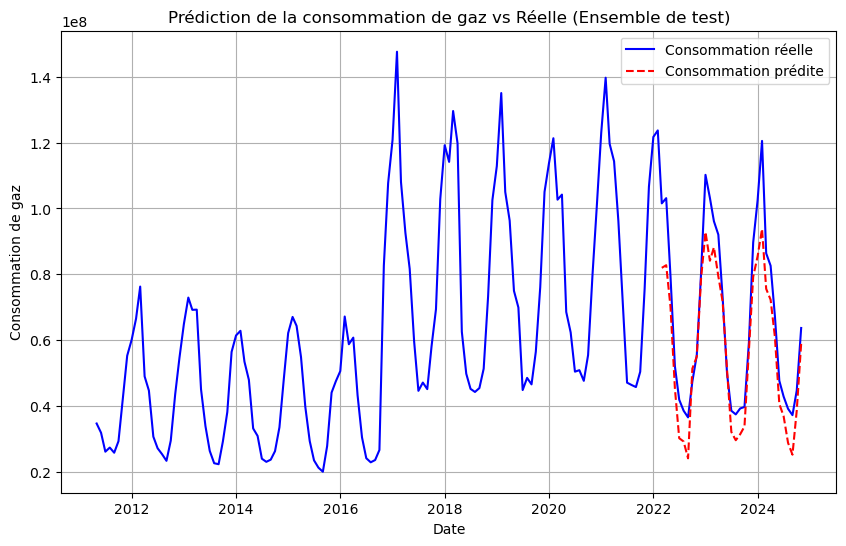

In [182]:
plt.figure(figsize=(10, 6))
plt.plot(gas_consumption_monthly.index, gas_consumption_monthly, label='Consommation réelle', color='blue')
plt.plot(test.index, y_pred, label='Consommation prédite', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Consommation de gaz')
plt.title('Prédiction de la consommation de gaz vs Réelle (Ensemble de test)')
plt.legend()
plt.grid(True)
plt.show()


In [187]:
train

,consumption,temperature_2m_mean (°C),sunshine_duration (h),wind_speed_10m_max (km/h)
2011-04-30,3.461649e+07,12.023333,9.606144,18.616667
2011-05-31,3.179633e+07,15.151613,12.390272,17.793548
2011-06-30,2.605131e+07,18.586667,12.282489,17.793333
2011-07-31,2.729786e+07,17.629032,7.974557,19.161290
2011-08-31,2.573426e+07,18.693548,10.855684,17.200000
...,...,...,...,...
2021-09-30,5.035628e+07,16.036667,8.109459,16.990000
2021-10-31,7.560403e+07,10.564516,6.086750,19.877419
2021-11-30,1.066178e+08,5.950000,2.445496,18.876667
2021-12-31,1.217233e+08,1.638710,1.543777,18.770968


## Ridge Regression

In [190]:
# Définir la taille de l'ensemble d'entraînement
train_size = 0.8  # 80% pour l'entraînement, 20% pour le test

# Diviser les données en ensembles d'entraînement et de test
train, test = train_test_split(
    pd.concat([gas_consumption_monthly, temp_2m_mean_monthly, sunshine_dur_monthly, wind_speed_10m_max_monthly], axis=1),
    test_size=1 - train_size, shuffle=False
)

X_train = train[['temperature_2m_mean (°C)', 'sunshine_duration (h)', 'wind_speed_10m_max (km/h)']].values
y_train = train['consumption'].values

X_test = test[['temperature_2m_mean (°C)', 'sunshine_duration (h)', 'wind_speed_10m_max (km/h)']].values
y_test = test['consumption'].values

model = make_pipeline(
    MinMaxScaler(),
    Ridge(alpha=1.0)
)

# Entraîner le modèle sur l'ensemble d'entraînement
model.fit(X_train, y_train)

# Prédire les valeurs de consommation sur l'ensemble de test
y_pred = model.predict(X_test)

# Calculer l'erreur quadratique moyenne (MSE) sur l'ensemble de test
mse = mean_squared_error(y_test, y_pred)
print(f'MSE (Ridge Regression avec MinMaxScaler): {mse}')

# Calculer le coefficient de détermination R^2 sur l'ensemble de test
r2 = r2_score(y_test, y_pred)
print(f'R^2 (Ridge Regression avec MinMaxScaler): {r2}')


MSE (Ridge Regression avec MinMaxScaler): 100434485021177.55
R^2 (Ridge Regression avec MinMaxScaler): 0.8533021537771595


In [195]:
y_pred

array([1.09092272e+08, 6.71877617e+07, 7.61863417e+07, 4.88509241e+07,
       3.15763171e+07, 3.73609399e+07, 2.50456201e+07, 4.84128972e+07,
       5.65666884e+07, 7.65980681e+07, 8.88635188e+07, 9.46561196e+07,
       9.33707017e+07, 8.46759490e+07, 7.06740912e+07, 5.03018321e+07,
       3.21610374e+07, 4.44399666e+07, 3.85522751e+07, 3.26334694e+07,
       7.36386488e+07, 9.22263444e+07, 1.00376230e+08, 1.03769896e+08,
       9.22401298e+07, 6.90197932e+07, 6.62623416e+07, 4.17599858e+07,
       3.98293434e+07, 3.49372234e+07, 2.98479286e+07, 5.53497871e+07,
       6.68465506e+07])

In [196]:
y_test

array([1.01534221e+08, 1.03119495e+08, 7.94006162e+07, 5.19770599e+07,
       4.18564254e+07, 3.85012140e+07, 3.64824511e+07, 4.73549444e+07,
       5.53829892e+07, 8.02434740e+07, 1.10205123e+08, 1.03185158e+08,
       9.61059944e+07, 9.20182891e+07, 7.29756024e+07, 4.97766001e+07,
       3.84933410e+07, 3.73841396e+07, 3.91971075e+07, 3.96407850e+07,
       5.92261635e+07, 8.96464917e+07, 1.02512740e+08, 1.20523277e+08,
       8.63518360e+07, 8.25755915e+07, 6.73080242e+07, 4.76038905e+07,
       4.28268358e+07, 3.91059369e+07, 3.71550955e+07, 4.46444230e+07,
       6.36528502e+07])

In [194]:
# Récupérer les coefficients du modèle
coefficients = model.named_steps['ridge'].coef_

scaler = model.named_steps['minmaxscaler']
min_values = scaler.data_min_
ranges = scaler.data_range_


coefficients_original_scale = coefficients / ranges


for feature, coef in zip(['temperature_2m_mean (°C)', 'sunshine_dur_monthly', 'wind_speed_10m_max_monthly'], coefficients_original_scale):
    print(f'Coefficient pour {feature}: {coef}')


Coefficient pour temperature_2m_mean (°C): -1987095.0156061237
Coefficient pour sunshine_dur_monthly: -2073490.4679533606
Coefficient pour wind_speed_10m_max_monthly: 2801921.2362296088


In [213]:
gas_consumption_monthly['consumption']

2011-04-30    3.461649e+07
2011-05-31    3.179633e+07
2011-06-30    2.605131e+07
2011-07-31    2.729786e+07
2011-08-31    2.573426e+07
                  ...     
2024-06-30    4.282684e+07
2024-07-31    3.910594e+07
2024-08-31    3.715510e+07
2024-09-30    4.464442e+07
2024-10-31    6.365285e+07
Freq: M, Name: consumption, Length: 163, dtype: float64

In [217]:
mean_temp = temp_2m_mean_monthly.mean()
deltaTemp = temp_2m_mean_monthly - mean_temp

# Calcul du deltaConso (Conso - Moyenne(Conso))
mean_conso = gas_consumption_monthly['consumption'].mean()
deltaConso = gas_consumption_monthly['consumption'] - mean_conso


In [222]:
months = pd.Series([i % 12 + 1 for i in range(len(temp_2m_mean_monthly))])

# Calcul de la moyenne de chaque mois (par exemple, moyenne de janvier, février, etc.)
temp_monthly_avg = temp_2m_mean_monthly.groupby(months).mean()
gas_consumption_monthly_avg = gas_consumption_monthly.groupby(months).mean()

# Soustraction de la moyenne de chaque mois pour chaque année
deltaTemp = temp_2m_mean_monthly - months.map(temp_monthly_avg)
deltaConso = gas_consumption_monthly['consumption'] - months.map(gas_consumption_monthly_avg['consumption'])


In [226]:
temp_monthly_avg

Series([], Name: temperature_2m_mean (°C), dtype: float64)

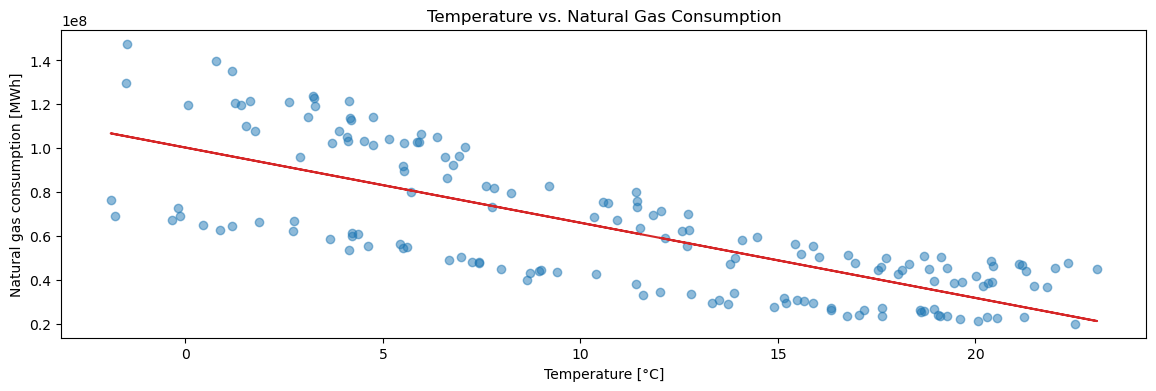

In [214]:
linear_regression = stats.linregress(temp_2m_mean_monthly, gas_consumption_monthly['consumption'])

#Plot linear regression
regression_y = linear_regression.slope * temp_2m_mean_monthly + linear_regression.intercept

#Scatter plot of temperature and natural gas consumption
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(temp_2m_mean_monthly, gas_consumption_monthly['consumption'], alpha=0.5)

#Plot linear regression
ax.plot(temp_2m_mean_monthly, regression_y, color="tab:red")

#Labels and legend
ax.set_xlabel("Temperature [°C]")
ax.set_ylabel("Natural gas consumption [MWh]")
ax.set_title("Temperature vs. Natural Gas Consumption")

#Save plot
fig.savefig("diagrams/reglin.svg", format="svg", bbox_inches="tight")


In [216]:
print(f"R-squared: {linear_regression.rvalue**2:.6f}")

R-squared: 0.580477


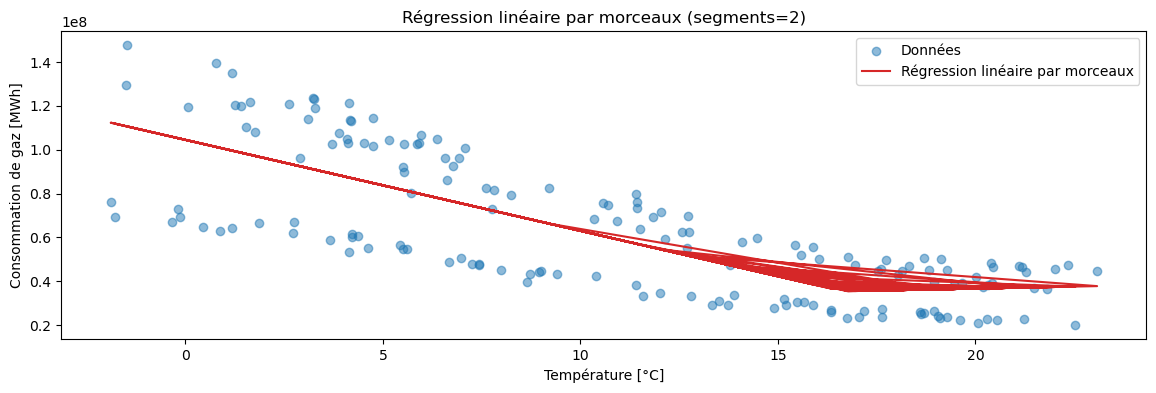

0.6044318574586505


In [232]:
X = temp_2m_mean_monthly.values
y = gas_consumption_monthly['consumption'].values

# Initialiser le modèle Piecewise Linear Fit
model = pwlf.PiecewiseLinFit(X, y)

# Choisir le nombre de segments (par exemple, 2 segments ici)
num_segments = 2
model.fit(num_segments)

# Prédictions
y_pred = model.predict(X)

# Tracer les données et la régression linéaire par morceaux
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(X, y, alpha=0.5, label="Données")
ax.plot(X, y_pred, color="tab:red", label="Régression linéaire par morceaux")

# Ajouter des labels et une légende
ax.set_xlabel("Température [°C]")
ax.set_ylabel("Consommation de gaz [MWh]")
ax.set_title(f"Régression linéaire par morceaux (segments={num_segments})")
ax.legend()

# Sauvegarder le graphique
fig.savefig("diagrams/piecewise_regression_pwlf.svg", format="svg", bbox_inches="tight")

# Afficher le graphique
plt.show()

rsq = model.r_squared()
print(rsq)

## Winter Regression

In [234]:
gas_consumption_cold_months 

,consumption
2011-10-31,4.260749e+07
2011-11-30,5.523092e+07
2011-12-31,6.002006e+07
2012-01-31,6.648466e+07
2012-02-29,7.624201e+07
...,...
2023-12-31,1.025127e+08
2024-01-31,1.205233e+08
2024-02-29,8.635184e+07
2024-03-31,8.257559e+07


In [235]:
temp_2m_mean_cold_months 

Date
2011-10-31    10.387097
2011-11-30     4.610000
2011-12-31     4.219355
2012-01-31     1.864516
2012-02-29    -1.893103
                ...    
2023-12-31     3.709677
2024-01-31     1.261290
2024-02-29     6.627586
2024-03-31     7.603226
2024-10-31    11.512903
Name: temperature_2m_mean (°C), Length: 79, dtype: float64

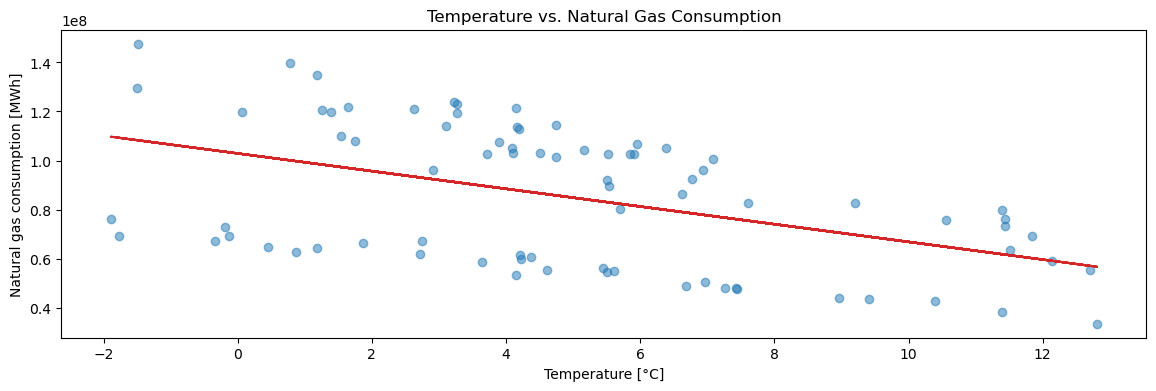

In [237]:
linear_regression = stats.linregress(temp_2m_mean_cold_months, gas_consumption_cold_months['consumption'])

#Plot linear regression
regression_y = linear_regression.slope * temp_2m_mean_cold_months + linear_regression.intercept

#Scatter plot of temperature and natural gas consumption
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(temp_2m_mean_cold_months, gas_consumption_cold_months['consumption'], alpha=0.5)

#Plot linear regression
ax.plot(temp_2m_mean_cold_months, regression_y, color="tab:red")

#Labels and legend
ax.set_xlabel("Temperature [°C]")
ax.set_ylabel("Natural gas consumption [MWh]")
ax.set_title("Temperature vs. Natural Gas Consumption")

#Save plot
fig.savefig("diagrams/reglin.svg", format="svg", bbox_inches="tight")


In [238]:
print(f"R-squared: {linear_regression.rvalue**2:.6f}")

R-squared: 0.223352
